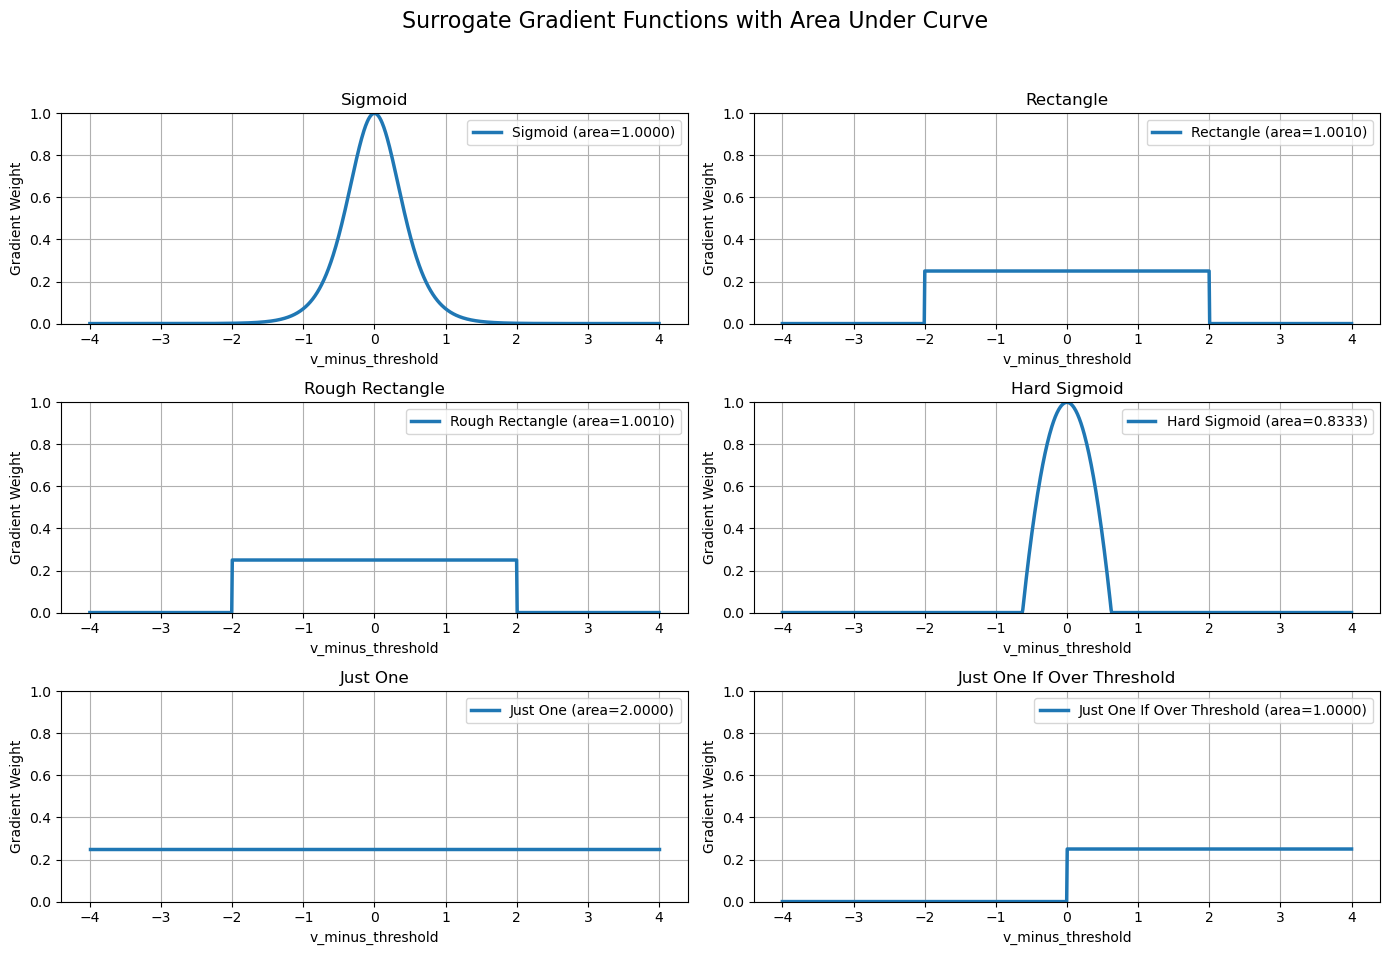

📐 Area under each surrogate gradient curve:
- Sigmoid: 1.000000
- Rectangle: 1.001001
- Rough Rectangle: 1.001001
- Hard Sigmoid: 0.833350
- Just One: 2.000000
- Just One If Over Threshold: 1.000000


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson

# surrogate 종류
surrogate_names = {
    1: "Sigmoid",
    2: "Rectangle",
    3: "Rough Rectangle",
    4: "Hard Sigmoid",
    5: "Just One",
    6: "Just One If Over Threshold"
}

# 설정
v = torch.linspace(-4, 4, steps=1000)
v2 = torch.linspace(-4, 4, steps=1000)
v_np = v2.numpy()
grad_output = torch.ones_like(v)
sg_width = 4.0

# subplot 설정
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

areas = {}  # 면적 저장용

for surrogate in range(1, 7):
    v_clone = v.clone()
    go = grad_output.clone()

    if surrogate == 1:
        alpha = sg_width
        sig = torch.sigmoid(alpha * v_clone)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 2:
        grad = (v_clone.abs() <= sg_width / 2).float() / sg_width
    elif surrogate == 3:
        go[v_clone.abs() > sg_width / 2] = 0
        grad = go / sg_width
    elif surrogate == 4:
        alpha = sg_width
        sig = torch.clamp(alpha * v_clone * 0.2 + 0.5, min=0, max=1)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 5:
        grad = torch.ones_like(v_clone) / sg_width
    elif surrogate == 6:
        go[v_clone < 0.0] = 0
        grad = go / sg_width

    grad_np = grad.numpy()
    area = simpson(grad_np, v_np)
    # area = np.trapz(grad_np, v_np)
    areas[surrogate_names[surrogate]] = area

    axs[surrogate - 1].plot(v_np, grad_np, label=f"{surrogate_names[surrogate]} (area={area:.4f})", linewidth=2.5)
    axs[surrogate - 1].set_title(surrogate_names[surrogate])
    axs[surrogate - 1].set_xlabel("v_minus_threshold")
    axs[surrogate - 1].set_ylabel("Gradient Weight")
    axs[surrogate - 1].grid(True)
    axs[surrogate - 1].set_ylim(0, 1)  # y축 고정
    axs[surrogate - 1].legend()

plt.suptitle("Surrogate Gradient Functions with Area Under Curve", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 면적 출력
print("📐 Area under each surrogate gradient curve:")
for name, area in areas.items():
    print(f"- {name}: {area:.6f}")


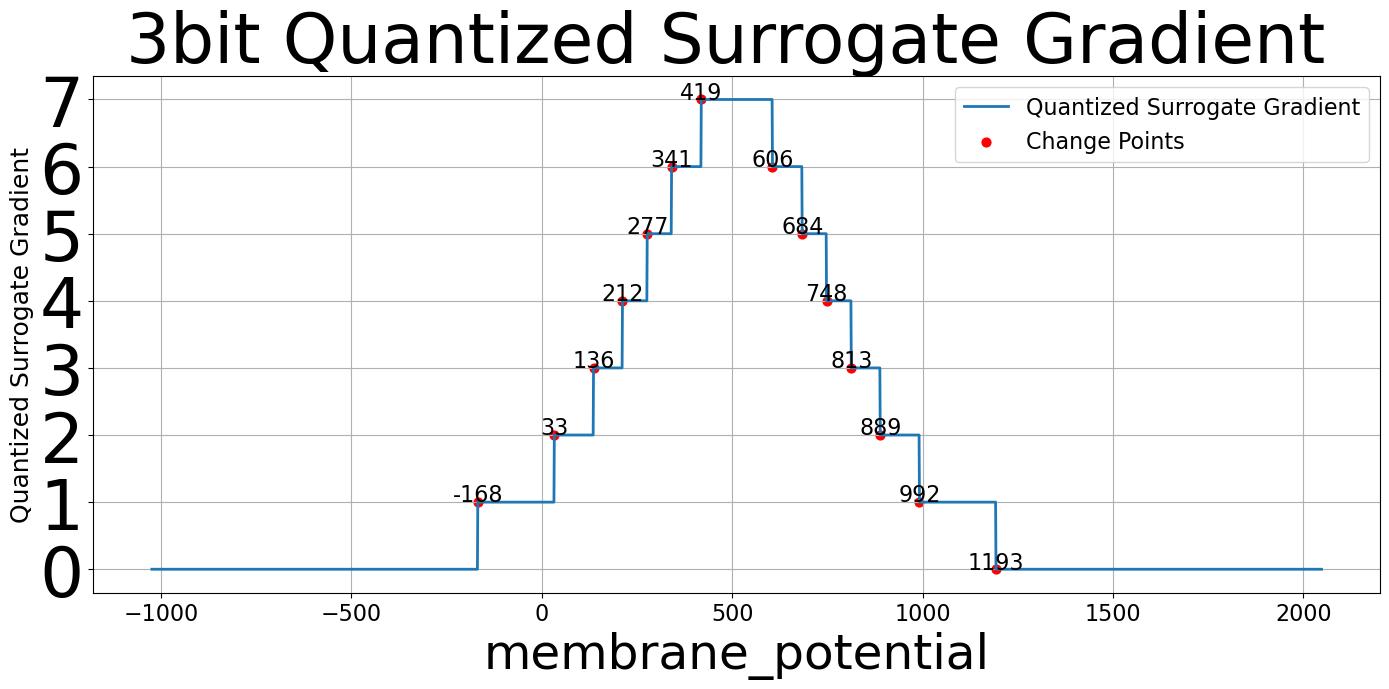

In [1]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Input range: from -1.5 to +1.5, include 0
step = 1 / 1024
v_vals_minus = torch.arange(0, -1.5 - step, -step)
v_vals_plus = torch.arange(step, 1.5 + step, step)
v_vals = torch.cat((v_vals_minus.flip(0), torch.tensor([0.0]), v_vals_plus))  # exact 0 included

# Surrogate gradient function
def sg(input):
    sig = torch.sigmoid(alpha * input)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized * 8

# Calculate quantized surrogate gradient
y = sg(v_vals)

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v_vals[change_indices] * 1024 + 512  # shift by +512
y_change = y[change_indices]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v_vals * 1024 + 512, y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()


# 밑 코드 쓰면 하이퍼파라미터로 x cut 바로 알 수 있음 

x_change_before_lr: tensor([-168.,   33.,  136.,  212.,  277.,  341.,  419.,  606.,  684.,  748.,
         813.,  889.,  992., 1193.])


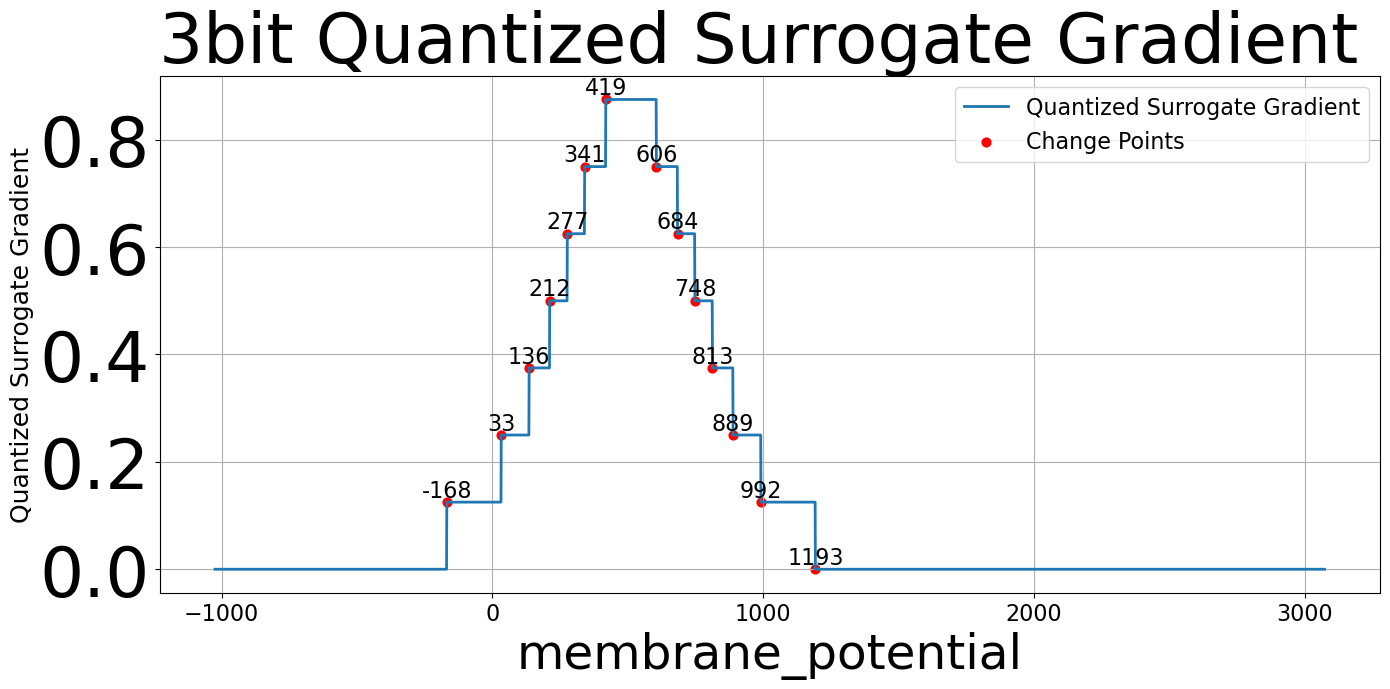

x_change_after_lr: tensor([ 33., 341., 684., 992.])


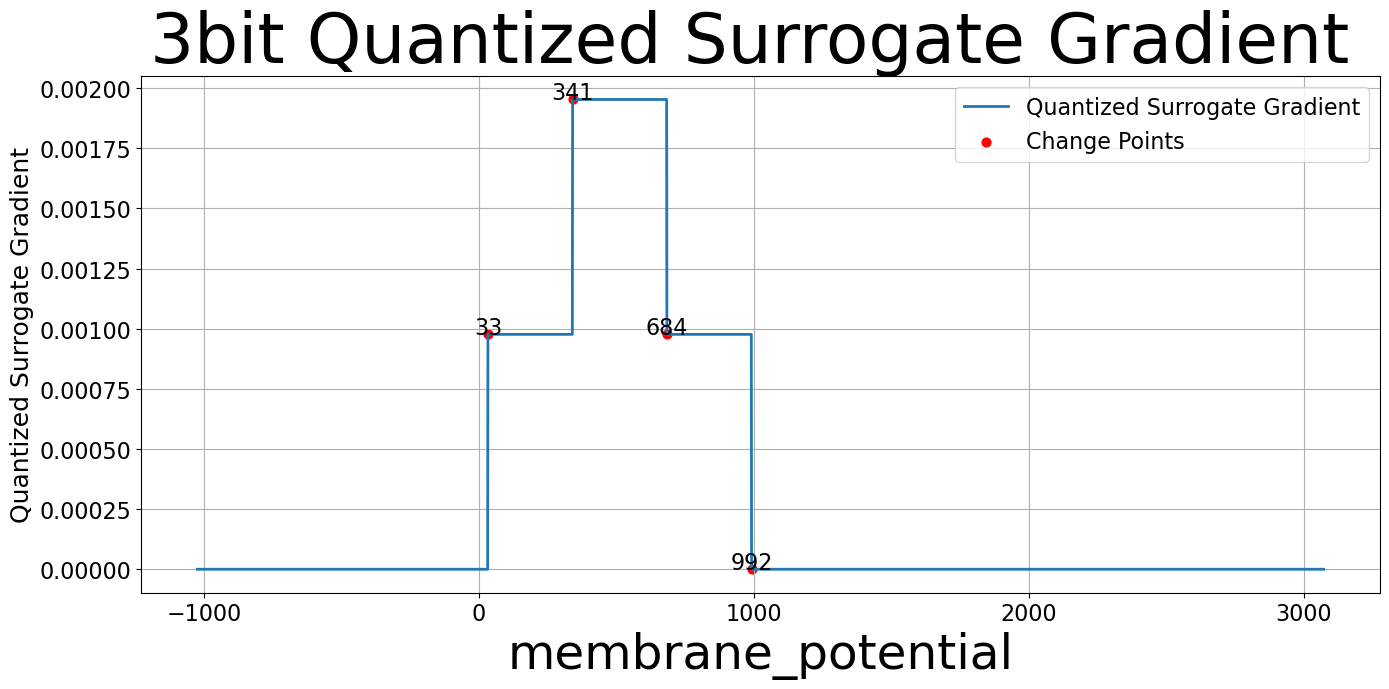

In [20]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
weight_exp = -10
threshold = 0.5
sg_width = 6.0
scale_v = 2**(-10)
v_bit = 15
dw_bit = 8
learning_rate = 1/512




alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# v = torch.arange(-2**v_bit, 2**v_bit + 1) * scale_v
v = torch.arange((-2**v_bit)/16 +((2**(-weight_exp))*threshold), (2**v_bit + 1)/16 + ((2**(-weight_exp))*threshold) +1) * scale_v

# Surrogate gradient function
def sg(v):
    sig = torch.sigmoid(alpha * v)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized
y = sg(v)


# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 
y_change = y[change_indices]
x_change_before_lr = x_change.clone()
#설명약간

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()


y = learning_rate * y  # Apply learning rate
y = torch.clamp(torch.sign(y / scale_v) * torch.floor(torch.abs(y / scale_v) + 0.5), -2**(dw_bit-1) + 1, 2**(dw_bit-1) - 1) * scale_v

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 

x_change_after_lr = x_change.clone()
#설명약간

y_change = y[change_indices]
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() , f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


print(f'x_change_before_lr: {x_change_before_lr}')
print(f'x_change_after_lr: {x_change_after_lr}')

surrogate_x_cut = []
for i in range(len(x_change_before_lr)):
    x_change_before_lr

In [23]:

print(f'x_change_before_lr: {x_change_before_lr}')
print(f'x_change_after_lr: {x_change_after_lr}')

now_cut = x_change_after_lr[0]

surrogate_x_cut = []
for i in range(len(x_change_before_lr)):
    if x_change_before_lr[i] in x_change_after_lr:
        now_cut = x_change_before_lr[i]
        surrogate_x_cut.append(x_change_before_lr[i])
    else:
        surrogate_x_cut.append(now_cut)

print(surrogate_x_cut)
    

# [33,341,684,684,684, 684,684,684,684,684, 684,684,684,992]

x_change_before_lr: tensor([-168.,   33.,  136.,  212.,  277.,  341.,  419.,  606.,  684.,  748.,
         813.,  889.,  992., 1193.])
x_change_after_lr: tensor([ 33., 341., 684., 992.])
[tensor(33.), tensor(33.), tensor(33.), tensor(33.), tensor(33.), tensor(341.), tensor(341.), tensor(341.), tensor(684.), tensor(684.), tensor(684.), tensor(684.), tensor(992.), tensor(992.)]


In [27]:
t = torch.tensor([341 - ((2**(-weight_exp))*threshold)])*scale_v
y = sg(t)
y = learning_rate * y  # Apply learning rate
y = torch.clamp(torch.sign(y / scale_v) * torch.floor(torch.abs(y / scale_v) + 0.5), -2**(dw_bit-1) + 1, 2**(dw_bit-1) - 1) * scale_v
print(y)

tensor([0.0020])


In [1]:
import torch

# 예시 입력: 같은 최대값이 두 개 존재 (3번째와 5번째)
input = torch.tensor([
    [1.0, 2.0, 5.0, 5.0, 3.0],   # 첫 번째 row
    [0.0, 7.0, 7.0, 1.0, 2.0]    # 두 번째 row
])

# 각 row별 최대값의 인덱스를 찾음
input_argmax = input.argmax(dim=1)

print("Input Tensor:\n", input)
print("Argmax 결과:\n", input_argmax)


Input Tensor:
 tensor([[1., 2., 5., 5., 3.],
        [0., 7., 7., 1., 2.]])
Argmax 결과:
 tensor([2, 1])


In [2]:
import torch

# 예시: 두 개의 샘플 (batch size = 2), 각 샘플마다 5개의 클래스 점수
outputs = torch.tensor([
    [0.2, 0.8, 0.8, 0.1, 0.3],  # 첫 번째 샘플: 1번과 2번 인덱스가 동일한 최대값
    [0.5, 0.5, 0.3, 0.2, 0.5]   # 두 번째 샘플: 0번, 1번, 4번 인덱스가 동일
])

_, predicted = torch.max(outputs.data, 1)

print("outputs:\n", outputs)
print("predicted:\n", predicted)


outputs:
 tensor([[0.2000, 0.8000, 0.8000, 0.1000, 0.3000],
        [0.5000, 0.5000, 0.3000, 0.2000, 0.5000]])
predicted:
 tensor([1, 0])
